# Object Detection using Sliding Window

We will be using concepts like Image Pyramid, Sliding Window and Non-Maxima Supression to turn almost any Image Classifier into an Object Detector
* **Image Pyramid**: 
  * An image pyramid is a multi-scale representation of an image, allowing us to find objects in images at different scales of an image.
  * At the bottom of the pyramid, we have the original image at its original size (in terms of width and height).
  * And at each subsequent layer, the image is resized (subsampled) and optionally smoothed (usually via Gaussian blurring).
  * The image is progressively subsampled until some stopping criterion is met, which is normally when a minimum size has been reached and no further subsampling needs to take place.
* **Sliding Window**:
  * A sliding window is a fixed-size rectangle that slides from left-to-right and top-to-bottom within an image.
  * At each stop of the window we would:
    * Extract the ROI
    * Pass it through our image classifier
    * Obtain the output predictions
* **Non-Maxima Supression**:
  * When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image.
  * We somehow need to collapse/remove the extraneous bounding boxes.
  * Non-maxima suppression (NMS) collapses weak, overlapping bounding boxes in favor of the more confident ones.
  
**Credits**: [PyImageSearch](https://pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/)

In [1]:
%%capture
!pip install imutils

In [2]:
import numpy as np
import argparse
import imutils
import time
import cv2

import tensorflow as tf
from tensorflow.keras.models import load_model

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt

11501568/11490434 [==============================] - 0s 0us/step


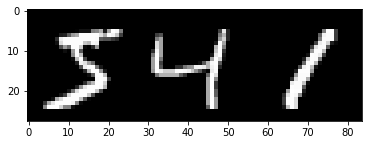

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
orig = np.zeros((28, 84))
orig[:, :28] = x_train[0]
orig[:, 28:56] = x_train[2]
orig[:, 56:] = x_train[3]
(H, W) = orig.shape[:2]
plt.imshow(orig, cmap='gray');

In [4]:
class SlidingWindowObjectDetection():
    def __init__(self, pretrained_classifier_path, **kwargs):
        self.model = load_model(pretrained_classifier_path)
        self.kwargs = kwargs
    
    def sliding_window(self, image, step, ws):
        for y in range(0, image.shape[0] - ws[1], step):
            for x in range(0, image.shape[1] - ws[0], step):
                yield (x, y, image[y:y + ws[1], x:x + ws[0]])

    def image_pyramid(self, image, scale=1.5, minSize=(28, 28)):
        yield image
        while True:
            w = int(image.shape[1] / scale)
            image = imutils.resize(image, width=w)
            if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
                break
            yield image   
            
    def get_rois_and_locs(self, pyramid):
        rois = []
        locs = []
        for image in pyramid:
            scale = W / float(image.shape[1])
            for (x, y, roiOrig) in self.sliding_window(image, self.kwargs['WIN_STEP'], self.kwargs['ROI_SIZE']):
                x = int(x * scale)
                y = int(y * scale)
                w = int(self.kwargs['ROI_SIZE'][0] * scale)
                h = int(self.kwargs['ROI_SIZE'][1] * scale)

                roi = cv2.resize(roiOrig, self.kwargs['INPUT_SIZE'])

                rois.append(roi)
                locs.append((x, y, x + w, y + h))
        return rois, locs
    
    def visualize_rois(self, rois):
        fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
        for ax, roi in zip(axes, rois):
            ax.imshow(roi, cmap='gray')
            
    def get_preds(self, rois, locs):
        rois = np.array(rois, dtype="float32")
        preds = self.model.predict(rois)
        preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
        labels = {}

        for (i, p) in enumerate(preds):
            (label, prob) = p
            if prob >= self.kwargs['MIN_CONF']:
                box = locs[i]
                L = labels.get(label, [])
                L.append((box, prob))
                labels[label] = L
        return preds, labels
    
    def apply_nms(self, labels):
        nms_labels = {}
        for label in sorted(labels.keys()):
            boxes = np.array([p[0] for p in labels[label]])
            proba = np.array([p[1] for p in labels[label]])
            boxes = non_max_suppression(boxes, proba)
            nms_labels[label] = boxes.tolist()
        return nms_labels
            
    def visualize_preds(self, img, nms_labels):
        for label in sorted(nms_labels.keys()):
            clone = img.copy()
            fig, ax = plt.subplots(figsize=(20, 6))
            boxes = nms_labels[label]
            for (startX, startY, endX, endY) in boxes:
                cv2.rectangle(clone, (startX, startY), (endX, endY), (255, 255, 255), 1)
                y = startY - 10 if startY - 10 > 10 else startY + 10
                cv2.putText(clone, str(label), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
            ax.imshow(clone, cmap='gray')
    
    def __call__(self, img):
        pyramid = self.image_pyramid(img, scale=self.kwargs['PYR_SCALE'], minSize=self.kwargs['ROI_SIZE'])
        rois, locs = self.get_rois_and_locs(pyramid)
        if self.kwargs['VIZ_ROIS']:
            self.visualize_rois(rois)
        preds, labels = self.get_preds(rois, locs)
        nms_labels = self.apply_nms(labels)
        
        if self.kwargs['VISUALIZE']:
            self.visualize_preds(img, nms_labels)
        
        return nms_labels

In [5]:
kwargs = dict(
    PYR_SCALE=1.25,
    WIN_STEP=7,
    ROI_SIZE=(21, 21),
    INPUT_SIZE=(28, 28),
    VISUALIZE=True,
    MIN_CONF=0.8,
    VIZ_ROIS=True
)

2022-04-01 17:43:06.076832: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-01 17:43:09.090518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Predictions:  {1: [[52, 0, 78, 26], [35, 0, 56, 21], [0, 0, 21, 21]], 2: [[14, 0, 35, 21]], 4: [[43, 0, 69, 26], [21, 0, 42, 21]], 5: [[0, 0, 26, 26]]}


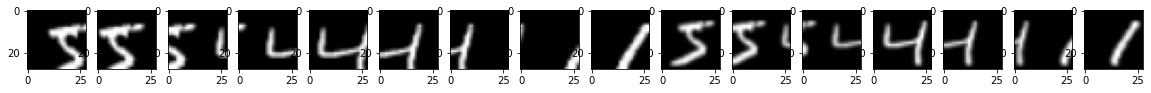

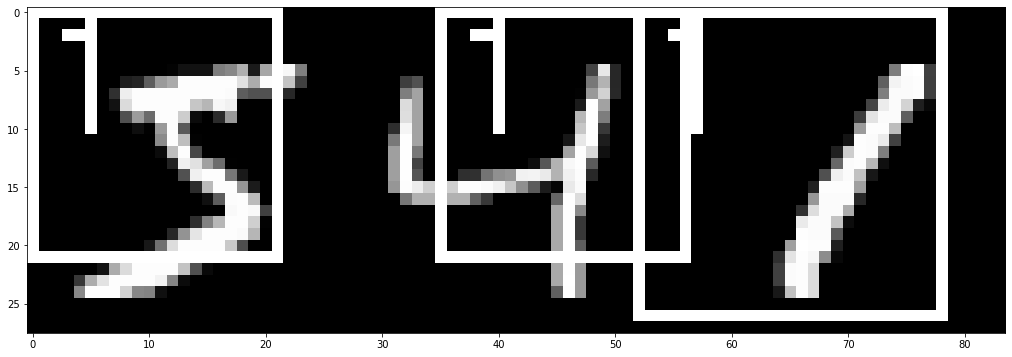

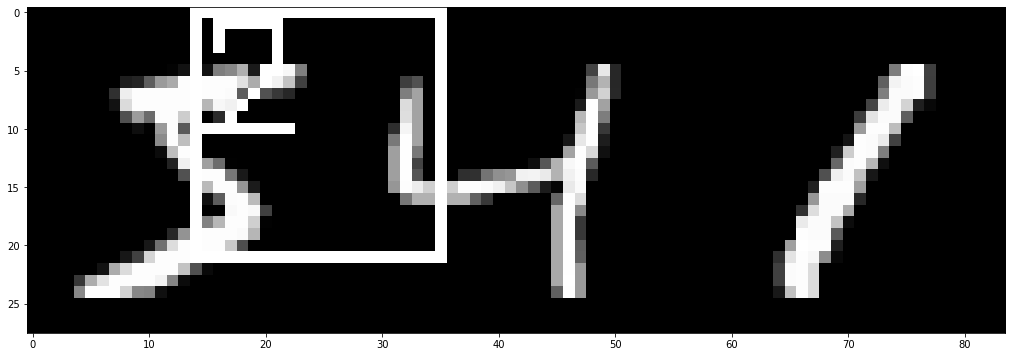

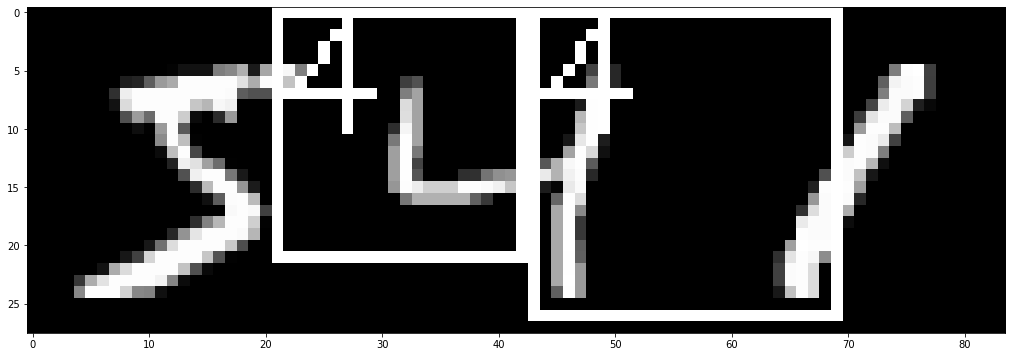

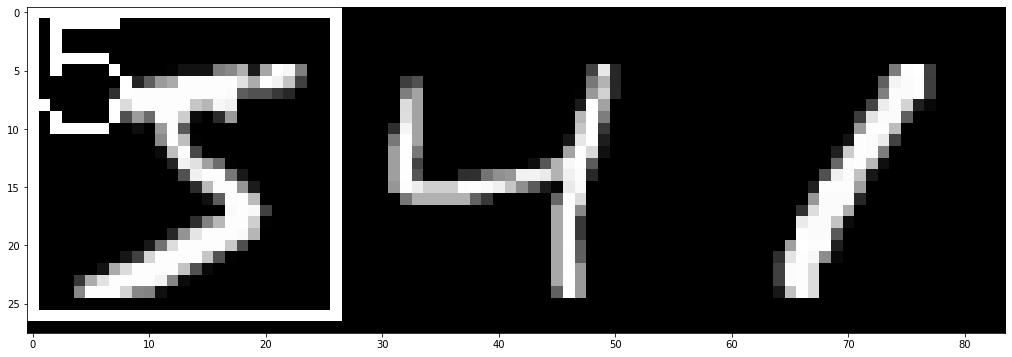

In [6]:
model = SlidingWindowObjectDetection('../input/mnist-net/mnist_net.h5', **kwargs)
preds = model(orig)
print("Predictions: ", preds)